In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import numpy as np
import pandas as pd
import scipy.sparse

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Mapping Dictionaries for Sentiment and Candidate Labels
sentiment_mapping = {0: 'Negative', 2: 'Neutral', 1: 'Positive'}
candidate_mapping = {0: 'BIDEN', 1: 'TRUMP'}

In [ ]:
# Custom Sparse-Dense Matrix Multiplication Layer
class SparseDenseMatMulLayer(Layer):
    def __init__(self, output_dim):
        super(SparseDenseMatMulLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.dense_weights = self.add_weight(
            name='dense_weights',
            shape=(input_shape[-1], self.output_dim),
            initializer='random_normal',
            trainable=True
        )

    def call(self, inputs):
        return tf.sparse.sparse_dense_matmul(inputs, self.dense_weights)

In [ ]:
# Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = X
        self.y = to_categorical(y, num_classes=3)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(self.X.shape[0])
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(self.X.shape[0] / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        batch_X = self.X[start_index:end_index]
        batch_y = self.y[start_index:end_index]

        if batch_X.shape[0] < self.batch_size:
            padding_size = self.batch_size - batch_X.shape[0]
            padding_matrix = scipy.sparse.csr_matrix((padding_size, batch_X.shape[1]))
            batch_X = scipy.sparse.vstack([batch_X, padding_matrix])
            batch_y = np.vstack([batch_y, np.zeros((padding_size, batch_y.shape[1]))])

        batch_X_coo = batch_X.tocoo()
        batch_X_sparse = tf.sparse.SparseTensor(
            indices=np.vstack((batch_X_coo.row, batch_X_coo.col)).T,
            values=batch_X_coo.data,
            dense_shape=batch_X_coo.shape
        )

        batch_X_sparse = tf.sparse.reorder(batch_X_sparse)

        return batch_X_sparse, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            self.X = self.X[self.indices]
            self.y = self.y[self.indices]

In [ ]:
# Mapping and Display Functions
def map_labels(df, candidate_col='Candidate', sentiment_col='Predicted Sentiment'):
    df[candidate_col] = df[candidate_col].map(candidate_mapping)
    df[sentiment_col] = df[sentiment_col].map(sentiment_mapping)
    return df

In [ ]:
def display_sentiment_counts(trump_biden_df, title):
    trump_biden_df = map_labels(trump_biden_df.copy(), candidate_col='Candidate', sentiment_col='Predicted Sentiment')
    sentiment_counts = trump_biden_df.groupby(['Candidate', 'Predicted Sentiment']).size().unstack(fill_value=0)
    print(f"{title}:\n", sentiment_counts)
    plot_individual_sentiments(sentiment_counts, title, adjusted=True)

In [ ]:
def display_original_sentiment_counts(trump_biden_df):
    original_df = trump_biden_df.copy()
    original_df = map_labels(original_df, candidate_col='Candidate', sentiment_col='sentiment')
    sentiment_counts = original_df.groupby(['Candidate', 'sentiment']).size().unstack(fill_value=0)
    print("Original Sentiment Counts:")
    print(sentiment_counts)
    plot_individual_sentiments(sentiment_counts, 'Sentiment Distribution Per Candidate')

In [ ]:
# Data Loading and Preprocessing
def preprocess_and_vectorize_chunks(file_path, max_features=5000, chunksize=1000):
    chunk_list = []
    sentiment_mapping = {'positive': 1, 'negative': 0, 'neutral': 2}

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk = chunk[['preprocessed_tweet', 'Candidate', 'sentiment']]
        chunk.dropna(subset=['preprocessed_tweet', 'Candidate', 'sentiment'], inplace=True)
        chunk = chunk[chunk['sentiment'].isin(sentiment_mapping.keys())]
        chunk['sentiment'] = chunk['sentiment'].map(sentiment_mapping)
        chunk['Candidate'] = chunk['Candidate'].apply(lambda x: 1 if x == 'TRUMP' else 0)
        chunk_list.append(chunk)

    trump_biden_df = pd.concat(chunk_list, axis=0)

    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X = tfidf_vectorizer.fit_transform(trump_biden_df['preprocessed_tweet'])
    y = trump_biden_df['sentiment'].values
    candidate = trump_biden_df['Candidate'].values

    return X, y, candidate, tfidf_vectorizer, trump_biden_df

In [ ]:
# Train-validation-test split
def train_validation_test_split(X, y, candidate, test_size=0.1, val_size=0.1, random_state=42):
    X_train_val, X_test, y_train_val, y_test, candidate_train_val, candidate_test = train_test_split(
        X, y, candidate, test_size=test_size, random_state=random_state)

    val_adjusted_size = val_size / (1 - test_size)

    X_train, X_val, y_train, y_val, candidate_train, candidate_val = train_test_split(
        X_train_val, y_train_val, candidate_train_val, test_size=val_adjusted_size, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test, candidate_train, candidate_val, candidate_test

In [ ]:
def compute_class_weights(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return dict(enumerate(class_weights))

In [ ]:
# Build a simple multi-class model
def build_multi_class_model(input_dim, num_classes,learning_rate=0.01):
    # Define sparse input tensor
    inputs = Input(shape=(input_dim,), sparse=True)
    sparse_dense_layer = SparseDenseMatMulLayer(output_dim=num_classes)(inputs)
    output_layer = Dense(num_classes, activation='softmax')(sparse_dense_layer)

    # Model creation
    model = Model(inputs=inputs, outputs=output_layer)
 # Compile the model with  learning rate
    optimizer = Adam(learning_rate=learning_rate)  # Set learning rate
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Additional Helper Functions
def train_model(model, data_generator, validation_data_generator, epochs, history_file=None):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        data_generator,
        epochs=epochs,
        validation_data=validation_data_generator,
        steps_per_epoch=len(data_generator),
        validation_steps=len(validation_data_generator),
        callbacks=[reduce_lr, checkpoint, early_stopping],
        verbose=1
    )

    # Save history to CSV after training is complete
    if history_file:
        directory = os.path.dirname(history_file)
        if not os.path.exists(directory):
            os.makedirs(directory)

        hist_df = pd.DataFrame(history.history)
        if not hist_df.empty:
            hist_df.to_csv(history_file, index=False)

    best_model_file = 'best_model.keras'
    return history, best_model_file

In [ ]:
def save_history_to_csv(history, history_file):
    hist_df = pd.DataFrame(history.history)
    if not hist_df.empty:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(history_file), exist_ok=True)
        hist_df.to_csv(history_file, index=False)

In [ ]:
def count_sentiments(trump_biden_df, candidate_column='Candidate', sentiment_column='sentiment'):
    sentiment_counts = trump_biden_df.groupby([candidate_column, sentiment_column]).size().unstack(fill_value=0)
    return sentiment_counts

In [ ]:
def plot_individual_sentiments(sentiment_counts, title, adjusted=False):
    # Map candidate indices to names
    candidates = ['BIDEN', 'TRUMP']
    index = np.arange(len(candidates))

    # Extract sentiment counts (assume the DataFrame has columns: Negative, Neutral, Positive)
    # Access sentiment counts by column names, not numerical index
    negative = sentiment_counts['Negative'].values  # Negative sentiment
    neutral = sentiment_counts['Neutral'].values if 'Neutral' in sentiment_counts else np.zeros(len(candidates)) # Neutral sentiment
    positive = sentiment_counts['Positive'].values  # Positive sentiment

    bar_width = 0.25  # Width of each bar

    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(index, negative, bar_width, label='Negative', color='navy')  # Plot negative sentiments
    if not adjusted and 'Neutral' in sentiment_counts:
        plt.bar(index + bar_width, neutral, bar_width, label='Neutral', color='gray')  # Plot neutral sentiments
    plt.bar(index + (bar_width if adjusted or 'Neutral' not in sentiment_counts else 2 * bar_width), positive, bar_width, label='Positive', color='gold')  # Plot positive sentiments

    # Adding labels, title, and legend
    plt.xlabel('Candidate')
    plt.ylabel('Number of Tweets')
    plt.title(title)
    plt.xticks(index + bar_width, candidates)  # Set x-ticks at the center of grouped bars
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='navy')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='gold')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='navy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='gold')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
# Evaluate_and_plot_metrics function:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
def evaluate_and_plot_metrics(model, X_test, y_test, roc_curve_file):
    # Create directory if it does not exist
    os.makedirs(os.path.dirname(roc_curve_file), exist_ok=True)
    X_test_coo = X_test.tocoo()

    # Create SparseTensor from COO representation
    X_test_sparse = tf.sparse.SparseTensor(
        indices=np.vstack((X_test_coo.row, X_test_coo.col)).T,
        values=X_test_coo.data,
        dense_shape=X_test_coo.shape
    )

    # Reorder indices to ensure correct ordering
    X_test_sparse = tf.sparse.reorder(X_test_sparse)

    # Make predictions with the sparse input
    y_pred = model.predict(X_test_sparse)


    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test  #In label format

    # Convert y_pred to integer labels by taking argmax along last axis
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Debugging checks
    print(f"y_test_labels shape: {y_test_labels.shape}, unique values: {np.unique(y_test_labels)}")
    print(f"y_pred_labels shape: {y_pred_labels.shape}, unique values: {np.unique(y_pred_labels)}")

    # Calculate metrics
    target_names = [sentiment_mapping[i] for i in range(3)]
    print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels, target_names=target_names))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC curves and AUC
    fpr, tpr, roc_auc = {}, {}, {}
    colors = ['gold', 'navy', 'grey']  # Colors for ROC curves
    for i, label in enumerate(target_names):
        fpr[i], tpr[i], _ = roc_curve((y_test_labels == i).astype(int), y_pred[:, i])
        roc_auc[i] = roc_auc_score((y_test_labels == i).astype(int), y_pred[:, i])

    # Plot ROC curves with specified colors
    plt.figure(figsize=(10, 8))
    for i, (label, color) in enumerate(zip(target_names, colors)):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{label} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve by Class')
    plt.legend(loc="lower right")
    plt.show()

    # Plot overall ROC curve (macro-average)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(target_names))]))
    mean_tpr = np.zeros_like(all_fpr)

    # Average TPR for each class
    for i in range(len(target_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(target_names)
    overall_auc = np.trapz(mean_tpr, all_fpr)

    # Customized plot for the overall ROC curve with a square/step appearance
    plt.figure(figsize=(6, 6))  # Square figure size
    plt.step(all_fpr, mean_tpr, color='navy', lw=2, where='post', label=f'Macro-average (area = {overall_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Overall ROC Curve (Macro-average)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.show()

    # Save overall ROC curve data to CSV
    roc_data = pd.DataFrame({'fpr': all_fpr, 'tpr': mean_tpr})
    roc_data.to_csv(roc_curve_file, index=False)
    print(f"ROC data saved to {roc_curve_file}")

    # Calculate and display accuracy

    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return accuracy, y_pred

In [ ]:
def distribute_neutral_sentiments(y_pred_labels, candidate_labels):
    """
    Redistributes predicted neutral sentiments (sentiment == 1) proportionally between positive (1) and negative (0)
    sentiments for each candidate based on the existing positive and negative sentiment distribution.

    Parameters:
    - y_pred_labels: Array of predicted sentiment labels (0 = Negative, 2 = Neutral, 1 = Positive).
    - candidate_labels: Array of candidate labels (0 = Biden, 1 = Trump).

    Returns:
    - redistributed_predictions: Array of redistributed predicted sentiment labels.
    """
    redistributed_predictions = np.copy(y_pred_labels)

    for candidate in np.unique(candidate_labels):  # Iterate through both candidates (Trump=1, Biden=0)
        candidate_mask = (candidate_labels == candidate)  # Mask for the current candidate
        candidate_predicted_labels = y_pred_labels[candidate_mask]  # Get predicted labels for this candidate

        # Count predicted positives, negatives, and neutrals
        positive_count = np.sum(candidate_predicted_labels == 1)
        negative_count = np.sum(candidate_predicted_labels == 0)
        neutral_count = np.sum(candidate_predicted_labels == 2)

        total_decided = positive_count + negative_count

        if total_decided > 0 and neutral_count > 0:  # Ensure there's something to redistribute
            # Calculate the share of positive and negative
            positive_share = positive_count / total_decided
            negative_share = negative_count / total_decided

            # Allocate neutrals proportionally
            allocated_positive = int(neutral_count * positive_share)
            allocated_negative = neutral_count - allocated_positive  # Remaining goes to negative

            # Get indices of predicted neutral sentiments
            neutral_indices = np.where((candidate_labels == candidate) & (y_pred_labels == 2))[0]

            # Redistribute neutrals to positive and negative
            redistributed_predictions[neutral_indices[:allocated_positive]] = 1  # Set to positive
            redistributed_predictions[neutral_indices[allocated_positive:]] = 0  # Set to negative

    return redistributed_predictions

In [ ]:
def calculate_adjusted_sentiment_share(adjusted_df, candidate_val):
    # Used 'Predicted Sentiment' instead of the original 'sentiment'
    positive_count = np.sum((adjusted_df['Candidate'] == candidate_val) & (adjusted_df['Predicted Sentiment'] == 2))
    total_count = np.sum(adjusted_df['Candidate'] == candidate_val)

    positive_share = positive_count / total_count if total_count > 0 else 0
    return positive_share


In [ ]:
def extract_polling_shares(polling_data):
    """
    Extracts raw polling shares for Trump, Biden, and Others,
    and normalizes them to ensure the total is 100%.
    """
    # Extract raw polling percentages
    trump_polling = polling_data[polling_data['candidate_name'] == 'Donald Trump']['pct'].mean()
    biden_polling = polling_data[polling_data['candidate_name'] == 'Joe Biden']['pct'].mean()
    others_polling = polling_data[polling_data['candidate_name'] == 'Other Candidates']['pct'].mean()

    # Handle missing values
    trump_polling = trump_polling if not np.isnan(trump_polling) else 0
    biden_polling = biden_polling if not np.isnan(biden_polling) else 0
    others_polling = others_polling if not np.isnan(others_polling) else 0

    # Sum of all raw percentages
    total_polling = trump_polling + biden_polling + others_polling

    # Normalize percentages to ensure total is 100%
    normalized_trump = (trump_polling / total_polling) * 100 if total_polling > 0 else 0
    normalized_biden = (biden_polling / total_polling) * 100 if total_polling > 0 else 0
    normalized_others = (others_polling / total_polling) * 100 if total_polling > 0 else 0

    # Print normalized polling percentages
    print("Raw Polling Percentages (Normalized):")
    print(f"Donald Trump: {normalized_trump:.2f}%, Joe Biden: {normalized_biden:.2f}%, Others: {normalized_others:.2f}%")

    return normalized_trump, normalized_biden, normalized_others

In [ ]:
def predict_election(positive_share_trump, positive_share_biden, polling_data, actual_others= 2.0, beta=0.8):
    """
    Predicts election outcome with the assumption that 'Others' receive less than 2% of the total vote.
    Excess 'Others' share is redistributed proportionally to Trump and Biden.

    Parameters:
    - positive_share_trump: Sentiment share for Trump.
    - positive_share_biden: Sentiment share for Biden.
    - polling_data: Polling data containing raw percentages.
    - actual_others: Assumed actual vote share for 'Others' (default: 1.9%).
    - beta: Decay factor to reduce the impact of 'Others' in polling data.

    Returns:
    - Normalized percentages for Trump, Biden, and Others, and the predicted winner.
    """
    # Extract raw polling percentages
    trump_polling = polling_data[polling_data['candidate_name'] == 'Donald Trump']['pct'].mean()
    biden_polling = polling_data[polling_data['candidate_name'] == 'Joe Biden']['pct'].mean()
    others_polling = polling_data[polling_data['candidate_name'] == 'Other Candidates']['pct'].mean()

    # Handle missing data (NaN)
    trump_polling = trump_polling if not np.isnan(trump_polling) else 0
    biden_polling = biden_polling if not np.isnan(biden_polling) else 0
    others_polling = others_polling if not np.isnan(others_polling) else 0

    # Apply decay factor to "Others" share
    adjusted_others_polling = others_polling * beta
    adjusted_others_polling = min(adjusted_others_polling, actual_others)  # Cap at assumed actual 'Others' share (e.g., 1.9%)

    # Redistribute excess "Others" proportionally to Trump and Biden
    excess_others = others_polling - adjusted_others_polling
    total_polling = trump_polling + biden_polling
    redistributed_trump = (excess_others * (trump_polling / total_polling)) if total_polling > 0 else 0
    redistributed_biden = (excess_others * (biden_polling / total_polling)) if total_polling > 0 else 0

    # Adjust Trump and Biden shares
    adjusted_trump = trump_polling + redistributed_trump
    adjusted_biden = biden_polling + redistributed_biden

    # Normalize polling shares to account for sentiment data
    polling_weight = 0.9
    sentiment_weight = 2
    final_trump_score = polling_weight * adjusted_trump + sentiment_weight * positive_share_trump
    final_biden_score = polling_weight * adjusted_biden + sentiment_weight * positive_share_biden

    # Normalize scores to sum to 100%
    total_votes = final_trump_score + final_biden_score + adjusted_others_polling
    normalized_trump = (final_trump_score / total_votes) * 100
    normalized_biden = (final_biden_score / total_votes) * 100
    normalized_others = (adjusted_others_polling / total_votes) * 100

    # Determine the winner
    winner = 'TRUMP' if normalized_trump > normalized_biden else 'BIDEN'

    # Print final results
    print(f"Trump Score: {normalized_trump:.2f}%, Biden Score: {normalized_biden:.2f}%, Others: {normalized_others:.2f}%")
    print(f"Predicted Winner: {winner}")

    return normalized_trump, normalized_biden, normalized_others, winner

In [ ]:
def plot_sentiment_vs_polling(trump_score, biden_score, winner):
    # Define candidates and their scores
    candidates = ['TRUMP', 'BIDEN', 'OTHERS']
    others_score = 100 - trump_score - biden_score
    scores = [trump_score, biden_score, others_score]
    colors = ['navy', 'gold', 'gray']

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(candidates, scores, color=colors, edgecolor='black', alpha=0.8)

    # Add text labels above each bar
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                 f"{score:.2f}%", ha='center', va='bottom', fontsize=12)

    # Customize the chart
    plt.ylabel('Score (%)', fontsize=14)
    plt.xlabel('Candidates', fontsize=14)
    plt.title(f'Predicted Election Outcome ({winner} Wins)', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 100)  # Ensure y-axis is scaled from 0 to 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis

    # Show the plot
    plt.tight_layout()
    plt.show()

Original Sentiment Counts:
sentiment  Negative  Neutral  Positive
Candidate                             
BIDEN         78502    84573    152159
TRUMP        157293   116426    154887


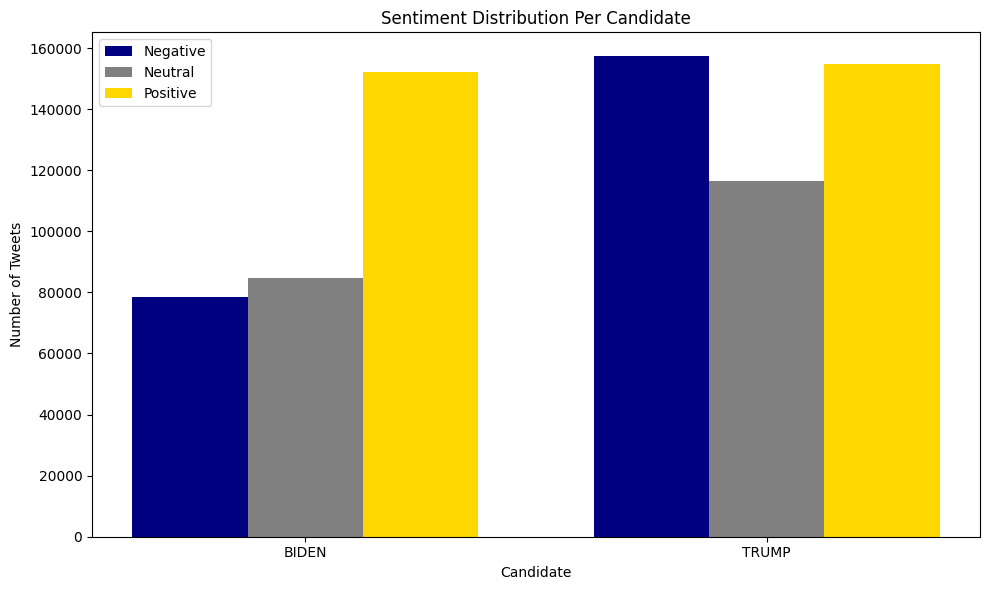

Epoch 1/100
18587/18596 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8106 - loss: 0.5264
Epoch 1: val_loss improved from inf to 0.45536, saving model to best_model.keras
18596/18596 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.8106 - loss: 0.5264 - val_accuracy: 0.8545 - val_loss: 0.4554 - learning_rate: 0.0100
Epoch 2/100
18586/18596 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8572 - loss: 0.4507
Epoch 2: val_loss improved from 0.45536 to 0.44653, saving model to best_model.keras
18596/18596 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step - accuracy: 0.8572 - loss: 0.4507 - val_accuracy: 0.8598 - val_loss: 0.4465 - learning_rate: 0.0100
Epoch 3/100
18580/18596 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8610 - loss: 0.4448
Epoch 3: val_loss improved from 0.44653 to 0.44284, saving model to best_model.keras
18596/18596 ━━━━━━━━━━━━━━━━━━━━ 140s 5ms/step - accuracy: 0.8610 - loss: 0.4448 - val_accuracy: 0.8627 - val_loss: 0.4428 - learning_rate: 0.0100
Epoch 4/100
18582/18596 ━━━━━━━━━━━━━

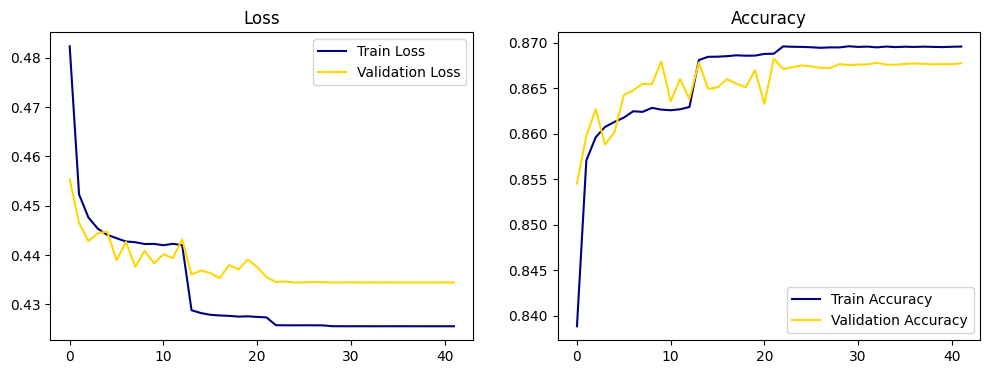

2325/2325 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
y_test_labels shape: (74384,), unique values: [0 1 2]
y_pred_labels shape: (74384,), unique values: [0 1 2]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.84      0.85     23677
    Positive       0.88      0.86      0.87     30703
     Neutral       0.86      0.91      0.88     20004

    accuracy                           0.87     74384
   macro avg       0.87      0.87      0.87     74384
weighted avg       0.87      0.87      0.87     74384



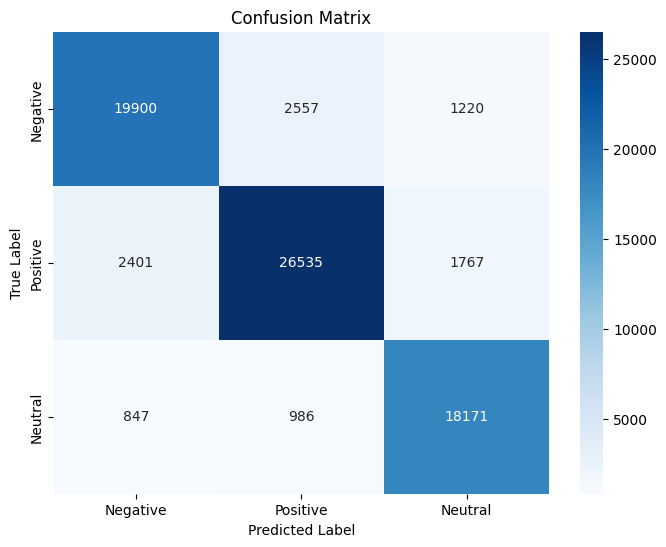

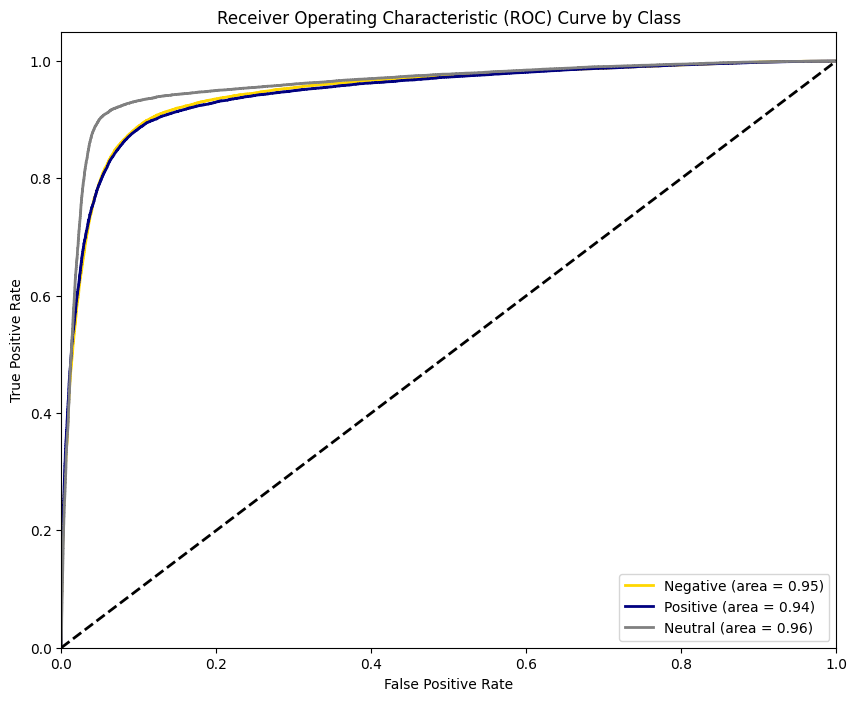

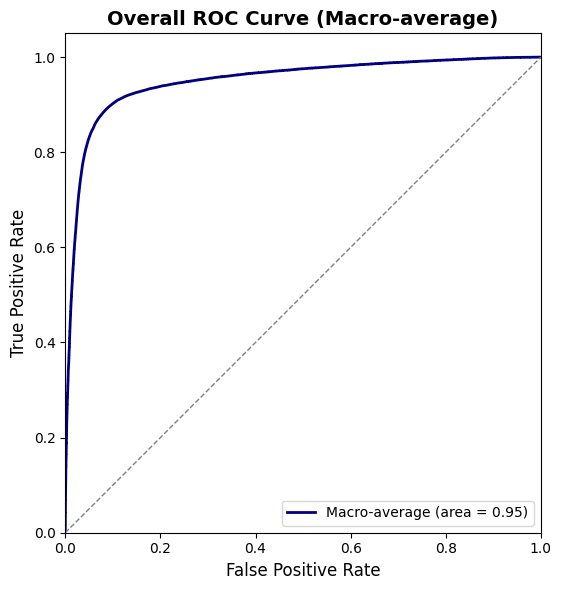

ROC data saved to /content/drive/MyDrive/models/histories/baseline_models/roc_curve/baseline_lr
Test Accuracy: 86.85%
Adjusted Sentiment Distribution (Neutral Redistributed):
 Predicted Sentiment  Negative  Positive
Candidate                              
BIDEN                   10642     20905
TRUMP                   21641     21196


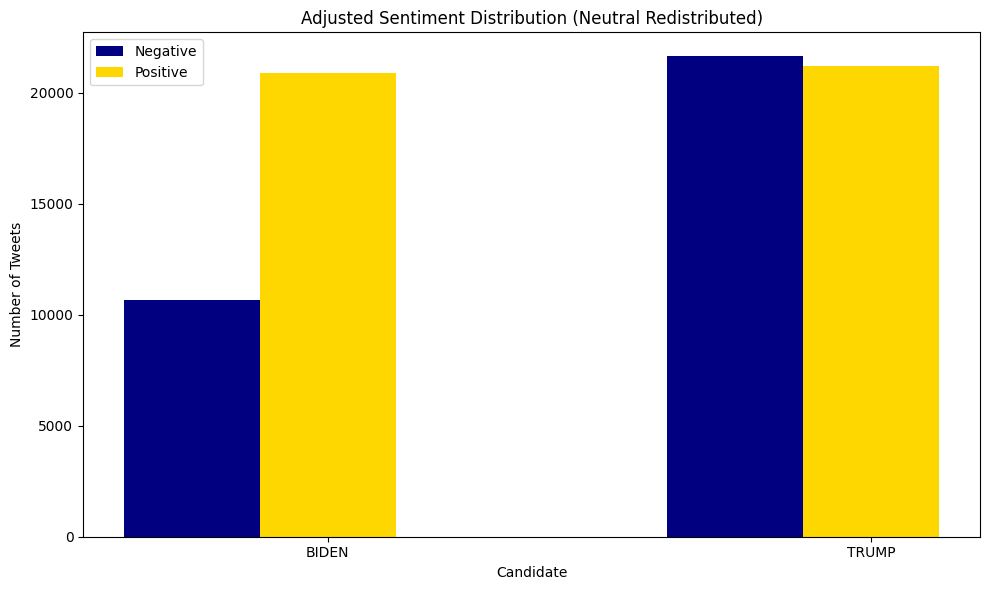

Trump - Positive: 15311, Negative: 15631, Neutral: 11895
Biden - Positive: 14767, Negative: 7517, Neutral: 9263
Positive Sentiment Shares: Trump: 0.36, Biden: 0.47
Negative Sentiment Shares: Trump: 0.36, Biden: 0.24
Neutral Sentiment Shares: Trump: 0.28, Biden: 0.29
Raw Polling Percentages (Normalized):
Donald Trump: 36.97%, Joe Biden: 41.46%, Others: 21.57%
Trump Score: 46.27%, Biden Score: 51.89%, Others: 1.84%
Predicted Winner: BIDEN
Predicted Results:
Trump: 46.27%, Biden: 51.89%, Others: 1.84%


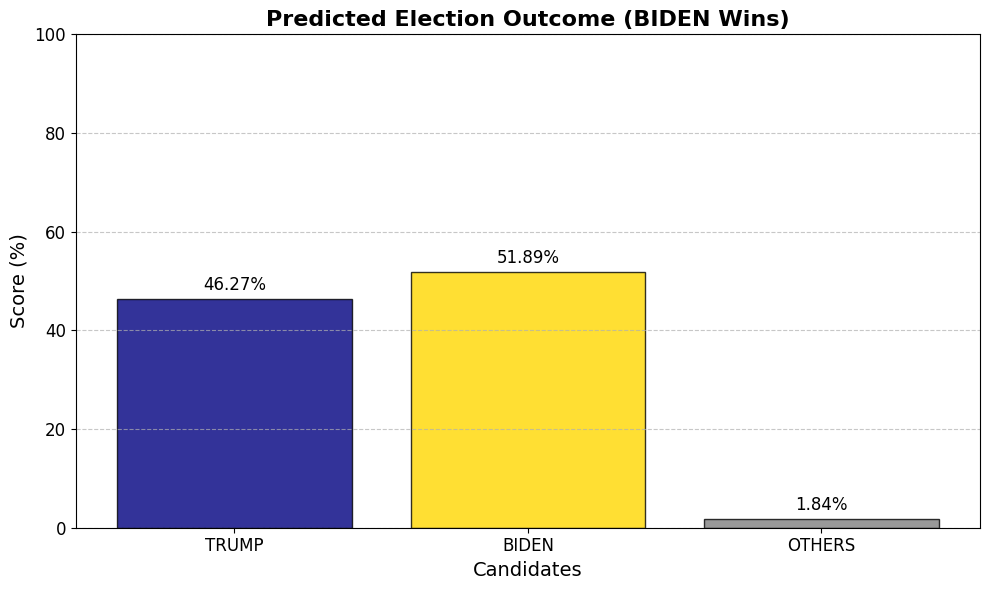

In [ ]:
# Main Function
def main():
    file_path = '/content/drive/MyDrive/preprocessed_datasets/1_1_filtered_trump_biden_df.csv'
    polling_data_path = '/content/drive/MyDrive/preprocessed_datasets/preprocessed_poll_data.csv'
    polling_data = pd.read_csv(polling_data_path)

    max_features = 5000
    chunksize = 1000

    # Data loading and preprocessing as before...
    X, y, candidate, tfidf_vectorizer, trump_biden_df = preprocess_and_vectorize_chunks(file_path, max_features=max_features, chunksize=chunksize)

    # Plot the original sentiment distribution
    display_original_sentiment_counts(trump_biden_df)

    # Split the data
    X_train, X_val, X_test, y_train, y_val, y_test, candidate_train, candidate_val, candidate_test = train_validation_test_split(
        X, y, candidate, test_size=0.1, val_size=0.1, random_state=42)

    input_dim = X_train.shape[1]
    num_classes = 3
    batch_size = 32
    epochs = 100

    # Create Data Generators
    train_data_generator = DataGenerator(X_train, y_train, batch_size=batch_size)
    validation_data_generator = DataGenerator(X_val, y_val, batch_size=batch_size)

    # Define and build the model before calling fit
    model = build_multi_class_model(input_dim, num_classes, learning_rate=0.01)

    # Train the model
    history = model.fit(
        train_data_generator,
        validation_data=validation_data_generator,
        epochs=epochs,
        verbose=1,
        callbacks=[
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
            ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
        ]
    )

    # Save the history to CSV
    history_file = '/content/drive/MyDrive/models/histories/baseline_models/accuracy/baseline_lr.csv'
    save_history_to_csv(history, history_file)
    plot_training_history(history)

    # Process evaluation metrics
    roc_curve_file = '/content/drive/MyDrive/models/histories/baseline_models/roc_curve/baseline_lr'
    accuracy, y_pred = evaluate_and_plot_metrics(model, X_test, y_test, roc_curve_file)

    # Redistribute neutral sentiments
    adjusted_y_pred_labels = distribute_neutral_sentiments(np.argmax(y_pred, axis=1), candidate_test)
    test_df = pd.DataFrame({'Candidate': candidate_test, 'True Sentiment': y_test, 'Predicted Sentiment': adjusted_y_pred_labels})
    display_sentiment_counts(test_df, 'Adjusted Sentiment Distribution (Neutral Redistributed)')

    # Calculate positive sentiment shares for Trump
    y_pred_labels = np.argmax(y_pred, axis=1)  # Define y_pred_labels here

    # Count sentiments for each candidate
    trump_positive = sum((candidate_test == 1) & (y_pred_labels == 1))
    trump_negative = sum((candidate_test == 1) & (y_pred_labels == 0))
    trump_neutral = sum((candidate_test == 1) & (y_pred_labels == 2))

    biden_positive = sum((candidate_test == 0) & (y_pred_labels == 1))
    biden_negative = sum((candidate_test == 0) & (y_pred_labels == 0))
    biden_neutral = sum((candidate_test == 0) & (y_pred_labels == 2))

    print(f"Trump - Positive: {trump_positive}, Negative: {trump_negative}, Neutral: {trump_neutral}")
    print(f"Biden - Positive: {biden_positive}, Negative: {biden_negative}, Neutral: {biden_neutral}")

    # Calculate sentiment shares
    positive_share_trump = trump_positive / sum(candidate_test == 1)
    positive_share_biden = biden_positive / sum(candidate_test == 0)
    neutral_share_trump = trump_neutral / sum(candidate_test == 1)
    neutral_share_biden = biden_neutral / sum(candidate_test == 0)
    negative_share_trump = trump_negative / sum(candidate_test == 1)
    negative_share_biden = biden_negative / sum(candidate_test == 0)

    print(f"Positive Sentiment Shares: Trump: {positive_share_trump:.2f}, Biden: {positive_share_biden:.2f}")
    print(f"Negative Sentiment Shares: Trump: {negative_share_trump:.2f}, Biden: {negative_share_biden:.2f}")
    print(f"Neutral Sentiment Shares: Trump: {neutral_share_trump:.2f}, Biden: {neutral_share_biden:.2f}")

    # Calculate sentiment shares
    positive_share_trump = calculate_adjusted_sentiment_share(pd.DataFrame({'Candidate': candidate_test, 'Predicted Sentiment': adjusted_y_pred_labels}), 1)
    positive_share_biden = calculate_adjusted_sentiment_share(pd.DataFrame({'Candidate': candidate_test, 'Predicted Sentiment': adjusted_y_pred_labels}), 0)

    # Calculate sentiment shares for Trump and Biden
    positive_share_trump = calculate_adjusted_sentiment_share(test_df, 1)
    positive_share_biden = calculate_adjusted_sentiment_share(test_df, 0)

    # Inside main()
    trump_polling, biden_polling, others_polling = extract_polling_shares(polling_data)

    # Predict election outcome using decay factor (beta)
    trump_score, biden_score, others_score, predicted_winner = predict_election(
        positive_share_trump, positive_share_biden, polling_data, actual_others= 2.0, beta= 0.6
    )

    print(f"Predicted Results:\nTrump: {trump_score:.2f}%, Biden: {biden_score:.2f}%, Others: {others_score:.2f}%")

    # Plot the predicted result
    plot_sentiment_vs_polling(trump_score, biden_score, predicted_winner)

if __name__ == "__main__":
    main()